## 複数の分類器で平均

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import numpy as np
import pandas as pd
from scipy import interp
from patsy import dmatrices
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.joblib import Parallel, delayed
from sklearn.tree._tree import DTYPE
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [3]:
def getDayOfYear(month, day): # ex. month = "mar", day = 15
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

train_df['dayofyear'] = np.vectorize(getDayOfYear)(train_df['month'], train_df['day'])
train_df['dayofweek'] = train_df['dayofyear'] % 7

In [4]:
def getPDayOfWeek(pdays):
    return -1 if pdays == -1 else pdays % 7

train_df['pdayofweek'] = np.vectorize(getPDayOfWeek)(train_df['pdays'])

In [5]:
# 質的変数をダミー変数化
y_, X_ = dmatrices('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + dayofyear + dayofweek + duration + campaign + pdays + pdayofweek + previous + poutcome', data=train_df, return_type='dataframe')
X = X_.values
y = y_.y.values

X_.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,age,balance,day,dayofyear,dayofweek,duration,campaign,pdays,pdayofweek,previous
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,1756.0,3.0,93.0,2.0,939.0,1.0,-1.0,-1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,1443.0,18.0,49.0,0.0,172.0,10.0,-1.0,-1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,36.0,436.0,13.0,103.0,5.0,567.0,1.0,595.0,0.0,2.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,63.0,474.0,25.0,25.0,4.0,423.0,1.0,-1.0,-1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,31.0,354.0,30.0,120.0,1.0,502.0,1.0,9.0,2.0,2.0


In [6]:
def evaluate_model(classifier, n_folds=6):
    cv = StratifiedKFold(y, n_folds=n_folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    print("Calculating fold: ", end="")
    for i, (train, test) in enumerate(cv):
        print(i+1, end=" ")
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])[:, 1]
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

    print("done!", end="")
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
class GbdtLrClassifier:
    def __init__(self, n_estimators=100, max_depth=3, C=1.0, penalty='l2'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.C = C
        self.penalty = penalty
        
        self.gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
        self.lr_model = LogisticRegression(C=C, penalty=penalty)
        self.enc = OneHotEncoder()
        
    def fit(self, X, y):
        self.gbdt_model.fit(X, y)
        self.enc.fit(self.getEachTreeDecision(X))
        self.lr_model.fit(self.extractFeaturesByGBDT(X), y)
        return self
    
    def predict_proba(self, X):
        return self.lr_model.predict_proba(self.extractFeaturesByGBDT(X))
        
    def getEachTreeDecision(self, X):
        out = Parallel(n_jobs=4)(delayed(self.my_func)(self.gbdt_model.estimators_[i, 0].tree_, X) for i in range(self.gbdt_model.n_estimators))
        return np.transpose(np.array(out))
    
    def extractFeaturesByGBDT(self, X):
        return self.enc.transform(self.getEachTreeDecision(X)).toarray()
    
    def my_func(self, tree, X):
            return tree.apply(np.array(X, dtype=DTYPE))
        
    def clone(self):
        return GbdtLrClassifier(self.n_estimators, self.max_depth, self.C, self.penalty)

In [8]:
class BaggingKFoldClassifier():
    def __init__(self, base_classifiers, n_folds):
        self.classifiers = []
        self.base_classifiers = base_classifiers
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.classifiers = []
        cv = StratifiedKFold(y, n_folds=self.n_folds)

        for base_classifier in self.base_classifiers:
            for i, (train, test) in enumerate(cv):
                if hasattr(base_classifier, 'get_params'):
                    classifier = clone(base_classifier)
                else:
                    classifier = base_classifier.clone()
                classifier.fit(X[train], y[train])
                self.classifiers.append(classifier)
        return self
    
    def predict_proba(self, X):
        probas_list = []
        for classifier in self.classifiers:
            probas_list.append(classifier.predict_proba(X))
        return np.array(probas_list).mean(axis=0)

In [9]:
gbdt_model = GradientBoostingClassifier(n_estimators=500)
# gbdt_lr_model = GbdtLrClassifier(n_estimators=1000, max_depth=7, C=0.001, penalty='l2')
rf_model = RandomForestClassifier(n_estimators=2000, n_jobs=multiprocessing.cpu_count())
xgb_model = XGBClassifier(n_estimators=500, max_depth=3, gamma=0, min_child_weight=10)

Calculating fold: 1 2 3 4 5 6 done!

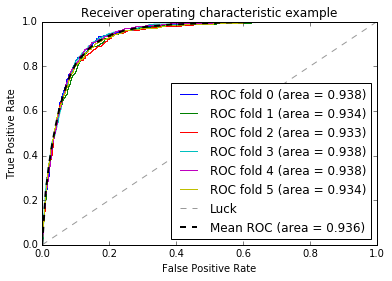

In [10]:
base_models = [xgb_model]
evaluate_model(BaggingKFoldClassifier(base_models, n_folds=6))

Calculating fold: 1 2 3 4 5 6 done!

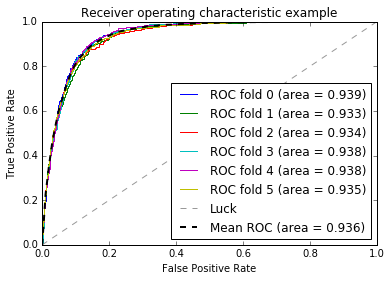

In [11]:
base_models = [gbdt_model, xgb_model]
evaluate_model(BaggingKFoldClassifier(base_models, n_folds=6))

Calculating fold: 1 2 3 4 5 6 done!

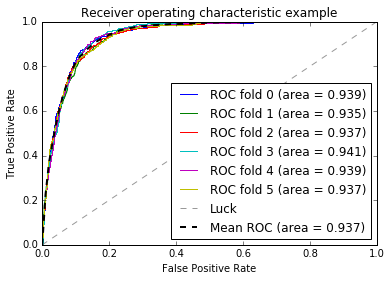

In [12]:
base_models = [gbdt_model, rf_model]
evaluate_model(BaggingKFoldClassifier(base_models, n_folds=6))

Calculating fold: 1 2 3 4 5 6 done!

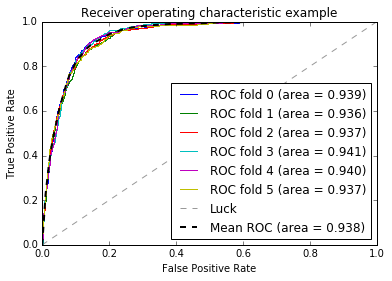

In [15]:
base_models = [xgb_model, rf_model]
evaluate_model(BaggingKFoldClassifier(base_models, n_folds=12))

Calculating fold: 1 2 3 4 5 6 done!

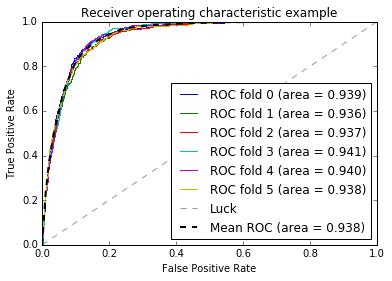

In [14]:
base_models = [gbdt_model, xgb_model, rf_model]
evaluate_model(BaggingKFoldClassifier(base_models, n_folds=6))